### More locally stable models on examples pulled from the dysts database of chaotic systems + bonus: best reduced-order models to-date for the lid-cavity flow
Here we test the locally stable trapping theorem on additional systems from the dysts database, https://github.com/williamgilpin/dysts, that (in principle) satisfy the totally-symmetric quadratic coefficient constraint. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps 
from scipy.integrate import solve_ivp
from trapping_utils import *

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

The local stability version of Trapping SINDy reduces to the following unconstrained optimization problem:
$$argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta^{-1} \lambda_1(\mathbf A) + \alpha^{-1}\|Q_{ijk}\| + \beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\beta \ll \alpha$.

A conservative estimate of the local stability is:
$$\rho_+ = \frac{3}{2r^{\frac{3}{2}}\epsilon_Q} \left( \sqrt{\lambda^2_{\text{max}}(\textbf{A}_S) - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3}\|\mathbf{d}\|_2} - \lambda_{\text{max}}(\textbf{A}_S) \right).$$
And the radius of the trapping region is given by:
$$\rho_- = -\frac{3}{2r^{\frac{3}{2}}\epsilon_Q} \left( \sqrt{\lambda^2_{\text{max}}(\textbf{A}_S) - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3}\|\mathbf{d}\|_2} + \lambda_{\text{max}}(\textbf{A}_S) \right).$$

### Dysts database contains a number of quadratically nonlinear chaotic systems with the special energy-preserving nonlinear symmetry.
You will need to install the dysts database with 'pip install dysts' or similar command (see https://github.com/williamgilpin/dysts) in order to load in the data.

In [2]:
import dysts.flows as flows

# List below picks out the polynomially nonlinear systems that are quadratic and
# exhibit the special structure in the quadratic coefficients.
trapping_system_list = np.array([2, 3, 7, 10, 18, 24, 27, 29, 30, 34, 40, 46, 47, 66, 67])
systems_list = [
                "Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = (np.array(systems_list)[alphabetical_sort])[trapping_system_list]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))

# Get training and testing trajectories for all the experimental systems 
n = 1000  # Trajectories with 1000 points
pts_per_period = 100  # sampling with 100 points per period
n_trajectories = 1  # generate n_trajectories starting from different initial conditions on the attractor
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,  # optionally start with initial conditions pushed slightly off the attractor
    include_transients=False,  # optionally do high-resolution sampling at rate proportional to the dt parameter 
    n_trajectories=n_trajectories
)

0 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
1 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
2 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
3 Hadley(name='Hadley', params={'a': 0.2, 'b': 4, 'f': 9, 'g': 1}, random_state=None)
4 HyperPang(name='HyperPang', params={'a': 36, 'b': 3, 'c': 20, 'd': 2}, random_state=None)
5 HyperYangChen(name='HyperYangChen', params={'a': 30, 'b': 3, 'c': 35, 'd': 8}, random_state=None)
6 Lorenz(name='Lorenz', params={'beta': 2.667, 'rho': 28, 'sigma': 10}, random_state=None)
7 LorenzStenflo(name='LorenzStenflo', params={'a': 2, 'b': 0.7, 'c': 26, 'd': 1.5}, random_state=None)
8 LuChen(name='LuChen', params={'a': 36, 'b': 3, 'c': 18}, random_state=None)
9 NoseHoover(name='NoseHoover', params={'a': 1.5}, random_state=None)
10 RayleighBenard(name='RayleighBenard', params={'a': 30, 'b': 5, 'r': 18}, random_state=None)
11 SprottA(name='SprottA', params={}, random_stat

#### Get some more information about the dynamical systems and their true equation coefficients

In [4]:
from dysts.equation_utils import make_dysts_true_coefficients

num_attractors = len(systems_list)

# Calculate some dynamical properties
lyap_list = []
dimension_list = []
param_list = []

# Calculate various definitions of scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


# Get the true coefficients for each system
true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)

# Need to reorder the calculated dysts equation coefficients to be 
# consistent with the SINDy library used below
reorder1 = np.array(
[0,
    1,
    2,
    3,
    5, # x^2 -> xy
    6, # xy -> xz
    8, # xz -> yz
    4, # y^2 -> x^2
    7, # yz -> y^2
    9, # z^2 -> z^2
])
reorder2 = np.array(
[0,
    1,
    2,
    3,
    4,
    6, # x^2 -> xy
    7, # xy -> xz
    8, # xz -> xw
    10, # xw -> yz
    11, # y^2 -> yw
    13, # yz -> zw
    5, # yw -> x^2
    9, # z^2 -> y^2
    12, # zw -> z^2
    14, # w^2 -> w^2
])

### Issues with using the trapping theorem with some of the dysts systems 
The trapping theorem and its variants require that systems are "effectively nonlinear", meaning there are no *invariant* linear subspaces where the system trajectories can escape to infinity. 

It turns out that Burke-Shaw, NoseHoover, SprottTorus, SprottA and SprottB are all not effectively nonlinear and exhibit subspaces where one of the coordinates can grow indefinitely! This is good the trapping theorem doesn't work for them -- these systems are *not* globally stable after all.

Actually, SprottTorus has no cubic terms in the energy at all (so the trapping theorem is thwarted), and is very challenging to evaluate the boundedness. However, numerical results seem to point to it being bounded for all practical purposes (https://sprott.physics.wisc.edu/pubs/paper423.pdf).

HyperPang, Chen, HyperYangChen, RayleighBernard, LuChen also not effectively nonlinear, but have stable linear (invariant) subspaces, usually (x=0, y=0, z, ...). Extending the trapping theorem to address these cases of global stability is work in progress.

Finally, the systems that do work with the trapping theorem: Finance, Hadley, Lorenz, LorenzStenFlo, VallisElNino.

We will illustrate how each of these systems produces a negative definite $\mathbf{A}^S$ matrix or "gets stuck" before this happens, which indicates a lack of effective nonlinearity and potential for unboundedness. 

0 BurkeShaw
nonlinearity preservation breaking =  7.074202335033419e-15
optimal m:  [-5.55719915e-01 -8.84063098e-04 -9.93011861e-01]
As eigvals:  [-9.94323767 -0.01162345  1.04351462]
Maximum deviation from having zero totally symmetric part:  7.074202335033419e-15
Estimate of trapping region size, Rm =  -85164859496709.7
Normalized trapping region size, Reff =  -85164859496709.7
Local stability size, R_ls=  -14.6061972956732
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  1.0000000000000004
1 Chen
nonlinearity preservation breaking =  5.950795411990839e-14
optimal m:  [-2.46695301 -0.52750102 28.75347443]
As eigvals:  [-34.95154043  -2.99452702  27.96658825]
Maximum deviation from having zero totally symmetric part:  5.950795411990839e-14
Estimate of trapping region size, Rm =  -271333765218501.
Normalized trapping region size, Reff =  -271333765218501.
Local stability size, R_ls=  -4.49816179876097
Simulated annealing managed to reduce the largest eige

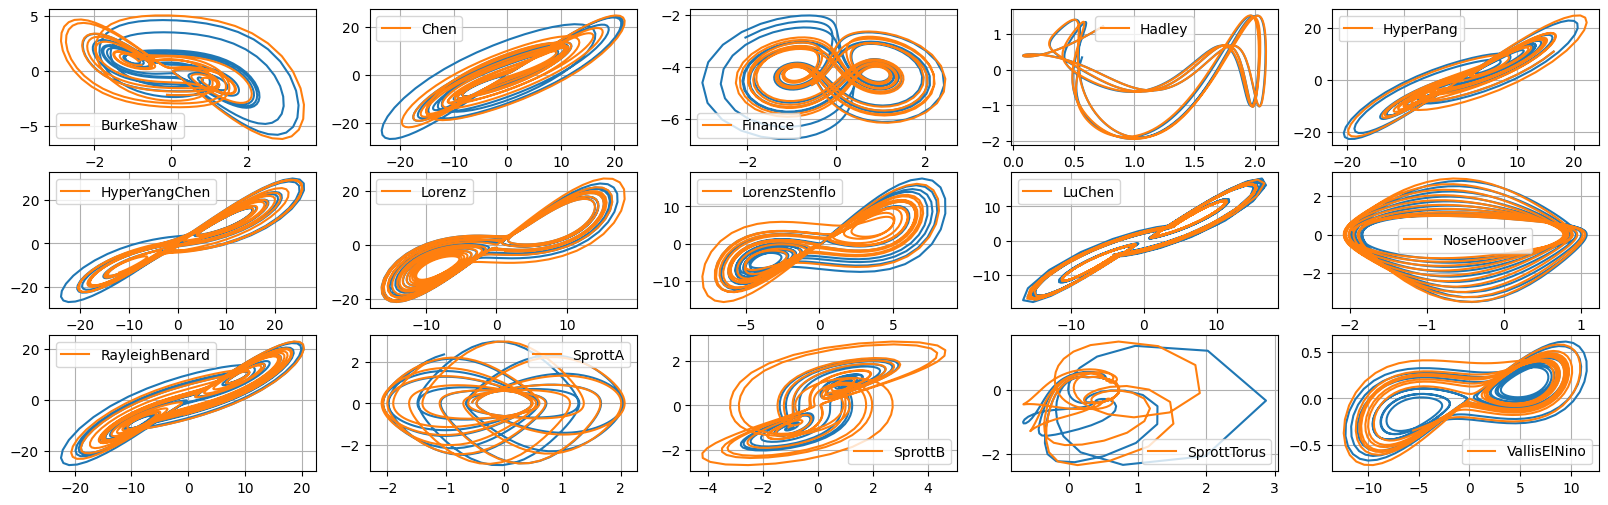

In [5]:
from scipy.optimize import dual_annealing as anneal_algo

# define hyperparameters
threshold = 0
max_iter = 5000
eta = 1.0e3
alpha_m = 4e-2 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

boundmax = 1000
boundmin = -1000

plt.figure(figsize=(20, 6))
for i in range(len(systems_list)):
    print(i, systems_list[i])
    r = dimension_list[i]
    
    # make training and testing data
    t = all_t_train[systems_list[i]][0]
    x_train = all_sols_train[systems_list[i]][0]
    x_test = all_sols_test[systems_list[i]][0]

    # run trapping SINDy
    constraint_zeros, constraint_matrix = make_constraints(r)
    sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                               accel=accel, max_iter=max_iter, gamma=-0.1,
                               constraint_lhs=constraint_matrix,
                               constraint_rhs=constraint_zeros,
                               constraint_order="feature",
                               # verbose=True
                               )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t, quiet=True)

    # Check the model coefficients and integrate it
    Xi = model.coefficients().T
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    print('nonlinearity preservation breaking = ', np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
    
    # Plot the integrated trajectories from the model
    plt.subplot(3, 5, i + 1)
    plt.plot(x_test[:, 0], x_test[:, 1])
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], label=systems_list[i])
    plt.grid(True)
    plt.legend()
    
    check_local_stability(r, Xi, sindy_opt, 1.0)
    Xi_true = (true_coefficients[i].T)[:Xi.shape[0], :]
    if r == 3:
        Xi_true = Xi_true[reorder1, :]
    else:
        Xi_true = Xi_true[reorder2, :]
        
    # run simulated annealing on the true system to make sure the system is amenable to trapping theorem
    boundvals = np.zeros((r, 2))
    boundvals[:, 0] = boundmin
    boundvals[:, 1] = boundmax
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    L = np.tensordot(PL_tensor, Xi_true, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PM_tensor, Xi_true, axes=([4, 3], [0, 1]))
    algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                           args=(L, Q, np.eye(r)), 
                           maxiter=500)
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    print('Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 = ', 
          opt_energy)
    # print('Optimal m = ', opt_m, '\n')
    
plt.show()

### Verify explicitly that some of the systems have unstable invariant linear or constant subspaces
These systems are not globally stable!

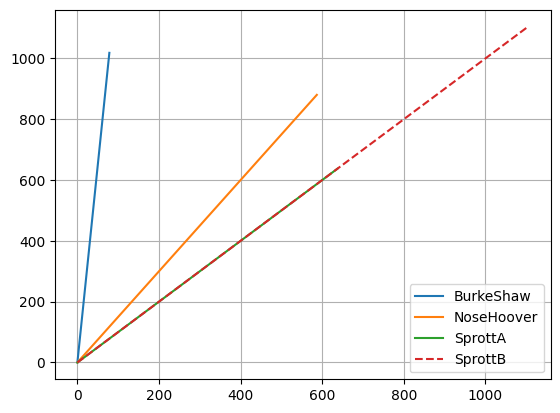

In [7]:
for system in ['BurkeShaw', 'NoseHoover', 'SprottA', 'SprottB']:
    eq = getattr(flows, system)()
    eq.ic = [0, 0, 0]
    t_sol, sol = eq.make_trajectory(
        10000,
        pts_per_period=100,
        resample=True,
        return_times=True,
        standardize=False,
    )
    style = 'solid'
    if system == 'SprottB':
        style = '--'
        
    # Show z-component flying off to infinity!
    plt.plot(t_sol, sol[:, 2], linestyle=style, label=system)

plt.grid(True)
plt.legend()
plt.show()

### Now repeat for locally stable models!
So, in practice there will be finite errors in the models that leads to a breaking of the constraint. 

0 Finance 3
nonlinearity preservation breaking =  1.064577790865721e-09
optimal m:  [-0.17912827 -5.18133049 -2.00152782]
As eigvals:  [-1.09359805 -0.26987735 -0.09953804]
Maximum deviation from having zero totally symmetric part:  1.064577790865721e-09
Estimate of trapping region size, Rm =  32.6561826820707
Normalized trapping region size, Reff =  32.6561826820707
Local stability size, R_ls=  53982224.9767040
Time-averaged derivative error =  1.1390164227531191e-07
Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 =  -0.20050148692708475
dt =  0.09903103103103103
Optimal m =  [-0.01018115 -2.74879419 -2.35667461] 

1 Hadley 3
nonlinearity preservation breaking =  3.844416474179122e-10
optimal m:  [-1.3380149  -0.06229067 -0.22219781]
As eigvals:  [-2.43505386 -2.33598622 -0.09947103]
Maximum deviation from having zero totally symmetric part:  3.844416474179122e-10
Estimate of trapping region size, Rm =  21.9395531450385
Normalized trapping region size, Reff

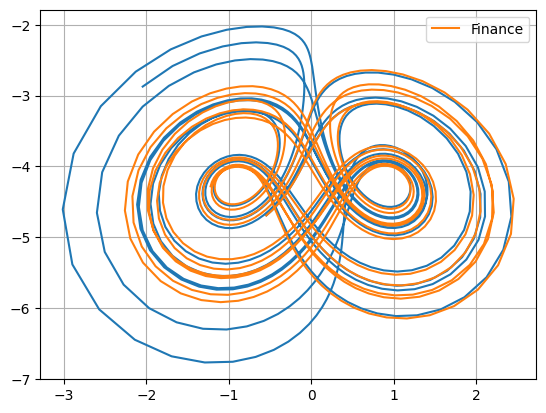

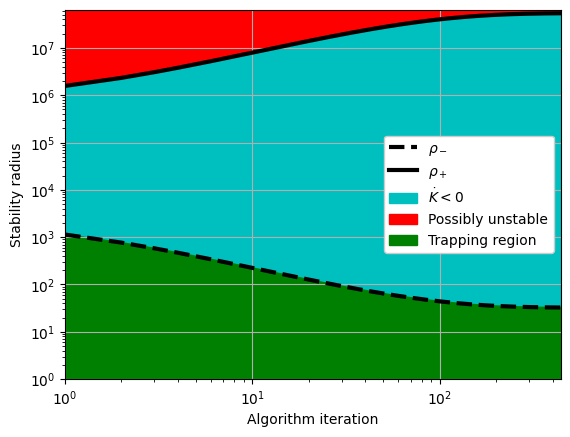

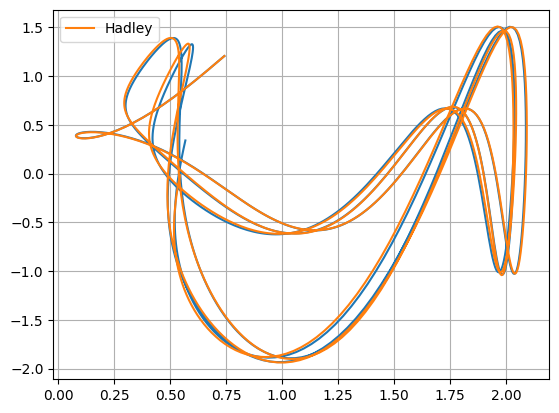

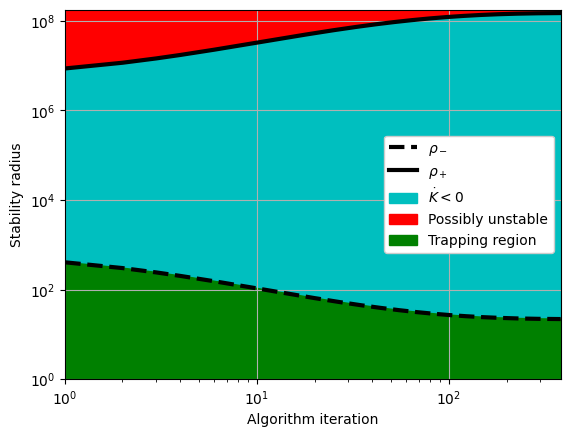

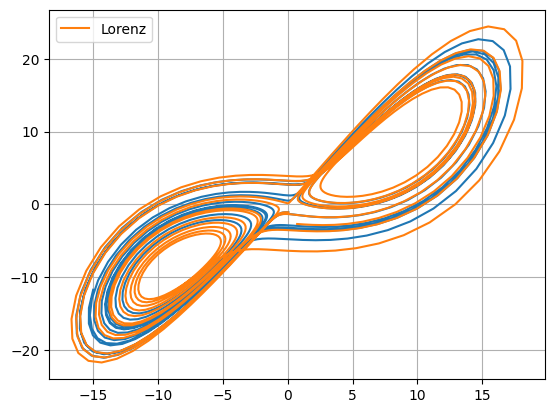

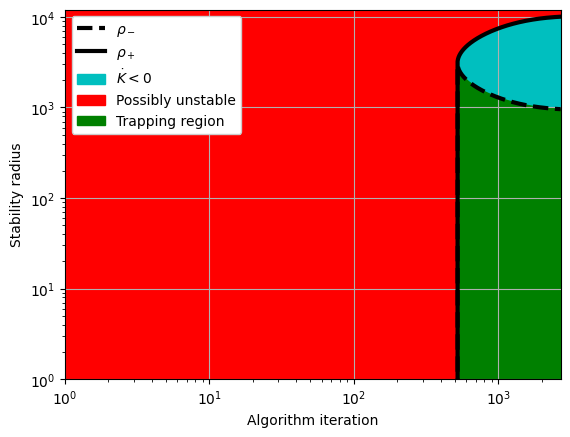

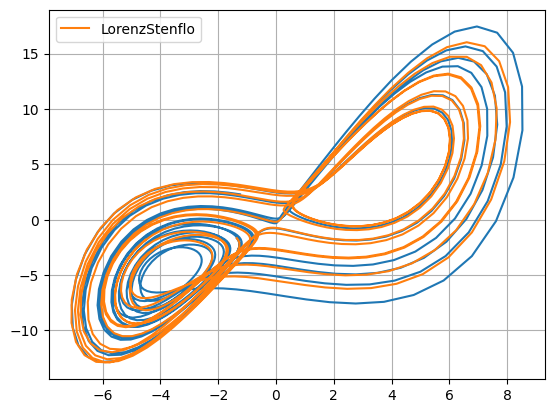

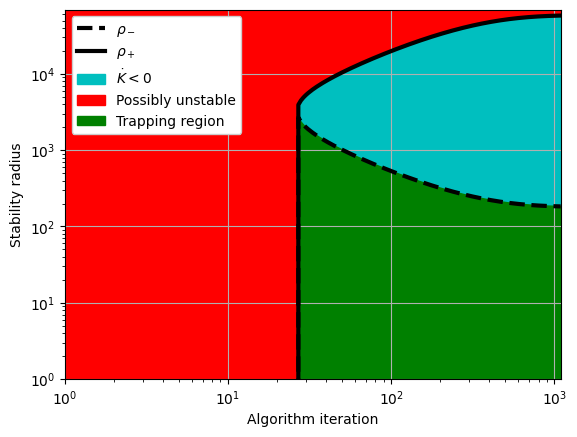

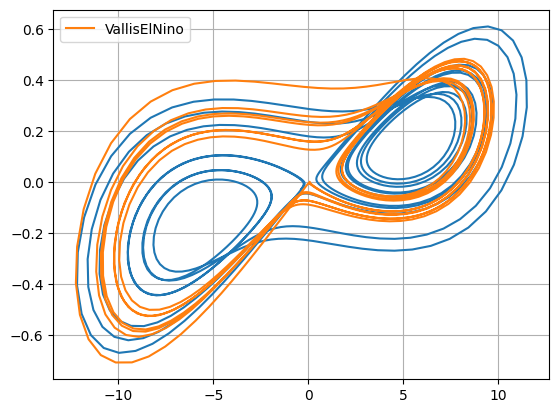

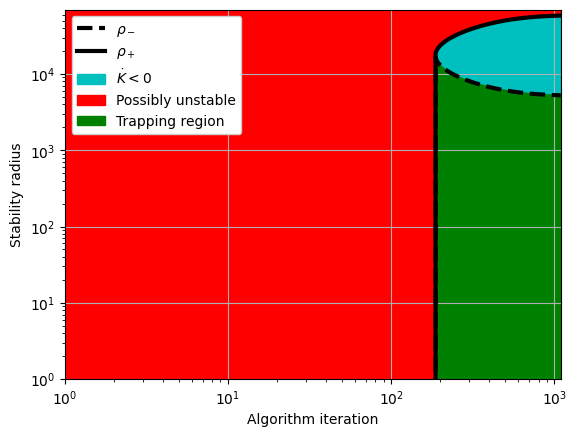

In [9]:
# define hyperparameters
threshold = 0
max_iter = 5000
eta = 1.0e3
alpha_m = 4e-2 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

stable_systems = [2, 3, 6, 7, 14]
stable_systems_list = systems_list[stable_systems]

for i in range(len(stable_systems_list)):
    r = dimension_list[stable_systems[i]]
    print(i, stable_systems_list[i], r)
    
    # make training and testing data
    t = all_t_train[stable_systems_list[i]][0]
    x_train = all_sols_train[stable_systems_list[i]][0]
    x_test = all_sols_test[stable_systems_list[i]][0]

    # run trapping SINDy, locally stable variant 
    # where the constraints are removed and beta << 1 
    sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                               accel=accel, max_iter=max_iter, gamma=-0.1,
                               beta=1e-9,
                               # verbose=True
                               )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t, quiet=True)

    # Check the model coefficients and integrate it
    Xi = model.coefficients().T
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    print('nonlinearity preservation breaking = ', np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
    
    # Check stability and try simulated annealing with the IDENTIFIED model
    check_local_stability(r, Xi, sindy_opt, 1.0)
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PM_tensor, Xi, axes=([4, 3], [0, 1]))
    boundvals = np.zeros((r, 2))
    boundvals[:, 0] = boundmin
    boundvals[:, 1] = boundmax
    
    # Compute time-averaged dX/dt error
    deriv_error = np.zeros(xdot_test.shape[0])
    for j in range(xdot_test.shape[0]):
        deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :],
                                xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                                xdot_test[i, :], xdot_test[i, :])
    print('Time-averaged derivative error = ', np.nanmean(deriv_error))

    # run simulated annealing on the IDENTIFIED system
    algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                           args=(L, Q, np.eye(r)), 
                           maxiter=500)
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    print('Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 = ', 
          opt_energy)
    print("dt = ", t[1]-t[0])
    print('Optimal m = ', opt_m, '\n')
    plt.figure()
    plt.plot(x_test[:, 0], x_test[:, 1])
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], label=stable_systems_list[i])
    plt.grid(True)
    plt.legend()
    path_str = "F:/UW/MasterThesis/"
    plot_name = stable_systems_list[i]
    plot_path = path_str + plot_name + ".pdf"
    plt.savefig(plot_path)
    
    # Plot the rho_+ and rho_- estimates for the stable systems 
    if opt_energy < 0:
        plt.figure()
        rhos_minus, rhos_plus = make_trap_progress_plots(r, sindy_opt)
        plt.yscale('log')
        plt.ylim(1, rhos_plus[-1] * 1.2)
        progress_name = stable_systems_list[i] + "progress"
        progress_path = path_str + progress_name + ".pdf"
        plt.savefig(progress_path)

### Last demonstration: building locally stable reduced-order models for the lid-cavity flow
First we compute a Galerkin model at different levels of truncation. This is also done in the Example 14 Jupyter notebook so we gloss over the description here.

In [5]:
from scipy.io import loadmat

data = loadmat("../data/cavityPOD.mat")
t_dns = data['t'].flatten()
a_dns = data['a']

# Downsample the data
skip = 1
t_dns = t_dns[::skip]
a_dns = a_dns[::skip, :]
dt_dns = t_dns[1] - t_dns[0]
singular_vals = data['svs'].flatten()

class GalerkinROM():
    def __init__(self, file):
        model_dict = loadmat(file)
        self.C = model_dict['C'][0]
        self.L = model_dict['L']
        self.Q = model_dict['Q']
        
    def integrate(self, x0, t, r=None,
                  rtol=1e-3, atol=1e-6):
        if r is None: r=len(C)
            
        # Truncate model as indicated
        C = self.C[:r]
        L = self.L[:r, :r]
        Q = self.Q[:r, :r, :r]
            
        # RHS of POD-Galerkin model, for time integration
        rhs = lambda t, x: C + (L @ x) + np.einsum('ijk,j,k->i', Q, x, x)
        
        sol = solve_ivp(rhs, (t[0], t[-1]), x0[:r], t_eval=t, rtol=rtol, atol=atol)
        return sol.y.T
    
# Simulate Galerkin system at various truncation levels
galerkin_model = GalerkinROM('../data/cavityGalerkin.mat')

dt_rom = 1e-2
t_sim = np.arange(0, 300, dt_rom)

a0 = a_dns[0, :]

# Finally, build a r=6 and r=16 Galerkin model
a_gal6 = galerkin_model.integrate(a0, t_sim, r=6, rtol=1e-8, atol=1e-8)
a_gal16 = galerkin_model.integrate(a0, t_sim, r=16, rtol=1e-8, atol=1e-8)

### Now try building a locally stable trapping SINDy model now
It does not quite achieve the negative definite stability matrix, but it performs remarkably well.

In [6]:
r = 6  # POD truncation

x_train = a_dns[:, :r]
t_train = t_dns.copy()

threshold = 0.0
eta = 1.0e10
alpha_m = 1e-4 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster
beta = 1e-5
max_iter = 10000
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-0.1,
                           beta=beta,
                           verbose=True
                           )

# Fit the model
model = ps.SINDy(
    optimizer=sindy_opt, 
    feature_library=sindy_library,
)

model.fit(x_train, t=t_train, quiet=True)
Xi = model.coefficients().T
check_local_stability(r, Xi, sindy_opt, 1.0)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print('nonlinearity preservation breaking = ', 
      np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
    
# Fit a baseline model -- this is almost always an unstable model!
model_baseline = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0), 
    feature_library=ps.PolynomialLibrary(),
)
model_baseline.fit(x_train, t=t_train, quiet=True)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.580e-01 ... 1.374e-06 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 1000 ... 4.580e-01 ... 6.319e-10 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 2000 ... 4.580e-01 ... 2.165e-10 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 3000 ... 4.580e-01 ... 8.366e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 4000 ... 4.580e-01 ... 4.013e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 5000 ... 4.580e-01 ... 2.594e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 6000 ... 4.580e-01 ... 2.130e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 7000 ... 4.580e-01 ... 1.973e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 8000 ... 4.580e-01 ... 1.917e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
 9000 ... 4.580e-01 ... 1.895e-11 ... 0.00e+00 ... 2.26e-16 ... 1.93e-10 ... 4.58e-01
optimal m:  [ 0.02620272  0.06128143  0.0196758   0

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'],
      optimizer=STLSQ(threshold=0.0))

In [7]:
# Simulate the model
a_sindy = model.simulate(a0[:r], t_sim)
a_sindy_baseline = model_baseline.simulate(a0[:r], t_sim, integrator="odeint")

rE = 16
E_sindy = np.sum(a_sindy[:, :rE] ** 2, 1)
E_sindy_baseline = np.sum(a_sindy_baseline[:, :rE] ** 2, 1)
E_dns = np.sum(a_dns[:, :rE] ** 2, 1)
E_gal6 = np.sum(a_gal6[:, :rE] ** 2, 1)
E_gal16 = np.sum(a_gal16[:, :rE] ** 2, 1)

### Now we plot the trajectories and energy as function of time
Trapping SINDy model vastly outperforms the Galerkin models!

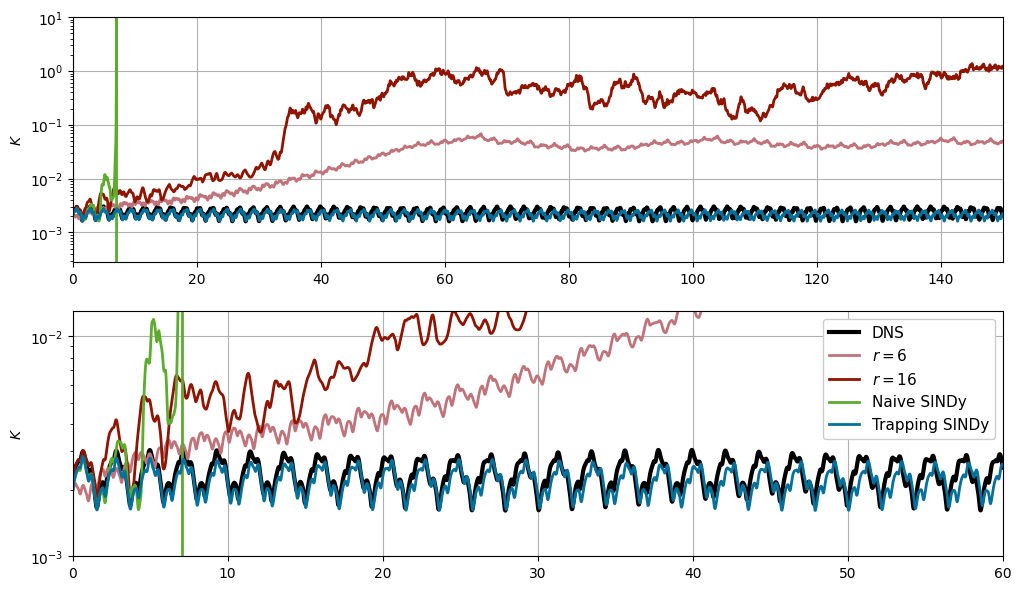

In [20]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy_baseline, label='Naive SINDy', lw=2, c='xkcd:grass')
plt.plot(t_sim, E_sindy, label='Trapping SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.ylabel('$K$')
plt.ylim([0, 10])
plt.xlim([0, 150])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy_baseline, label='Naive SINDy', lw=2, c='xkcd:grass')
plt.plot(t_sim, E_sindy, label='Trapping SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.legend(loc=1, fancybox=True, framealpha=1, fontsize=11)
plt.ylabel('$K$')
plt.ylim([1e-3, 1.3e-2])
plt.xlim([0, 60])
# plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.savefig('cavity_plot.pdf')
plt.show()

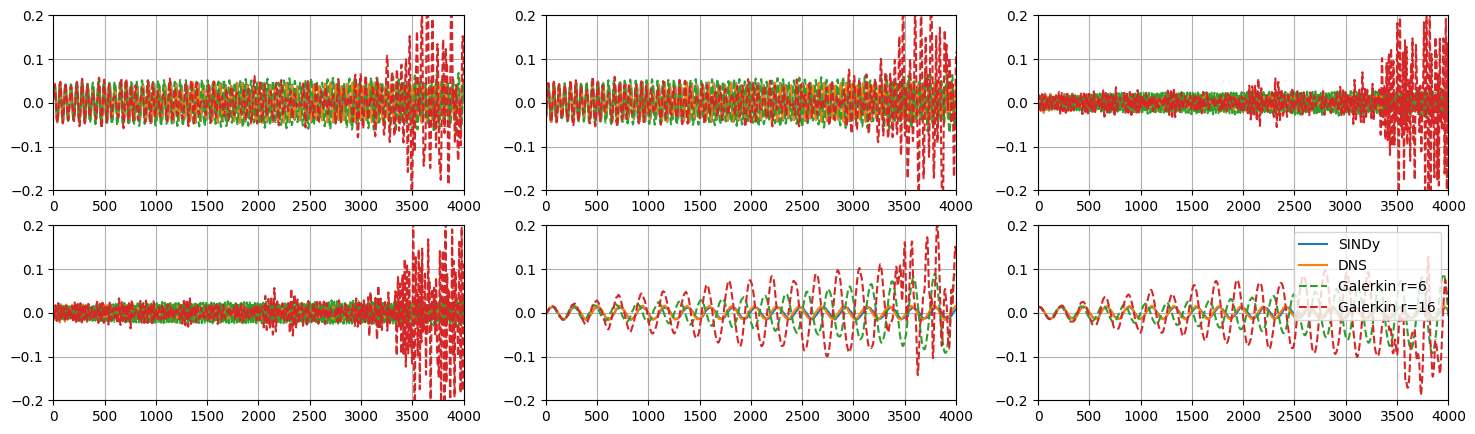

In [9]:
plt.figure(figsize=(18, 5))
for i in range(r):
    plt.subplot(2, r // 2, i + 1)
    plt.plot(a_sindy[:, i], label='SINDy')
    plt.plot(a_dns[:, i], label='DNS')
    plt.plot(a_gal6[:, i], '--', label='Galerkin r=6')
    plt.plot(a_gal16[:, i], '--', label='Galerkin r=16')
    if i == r - 1:
        plt.legend()
    plt.grid()
    plt.xlim(0, 4000)
    plt.ylim(-0.2, 0.2)

### Last check: Trapping SINDy model reproduces the power spectral density of the data

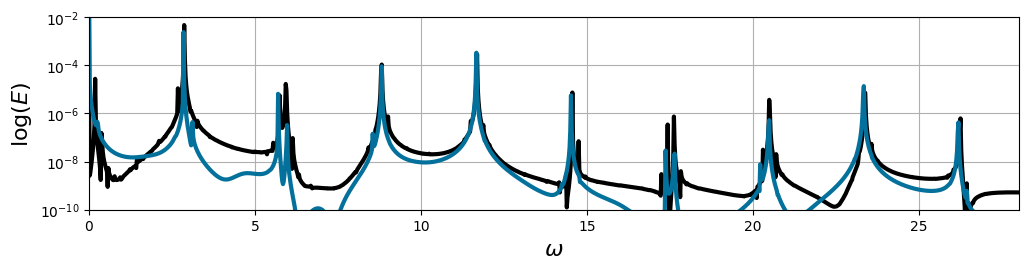

In [10]:
# Basic power spectral density estimate using FFT
def psd_est(E, dt=1):
    Ehat = np.abs((dt * np.fft.fft(E)) ** 2)
    Ehat = Ehat[:int(len(Ehat) / 2)]
    N = len(Ehat)
    freq = 2 * np.pi * np.arange(N) / (2 * dt * N)  # Frequencies in rad/s
    return Ehat, freq

psd, freq = psd_est(E_dns, dt=t_dns[1] - t_dns[0])
psd_sim, freq_sim = psd_est(E_sindy, dt=t_sim[1] - t_sim[0])

plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, 'k', lw=3)
plt.semilogy(freq_sim, psd_sim, 'xkcd:ocean blue', lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel('$\omega$', fontsize=16)
plt.ylabel('$\log(E)$', fontsize=16)
plt.grid()
plt.show()